In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, configure_plot_style, AIBM_COLORS

configure_plot_style()

## Read the data

In [3]:
!ls *.csv

owid_literacy.csv		wef_primary_enrolment.csv
wef_earned_income.csv		wef_primary_enrolment_table.csv
wef_economic_participation.csv	wef_professional_and_technical_workers.csv
wef_educational_attainment.csv	wef_secondary_enrolment.csv
wef_labour_participation.csv	wef_secondary_enrolment_table.csv
wef_legislators.csv		wef_tertiary_enrolment.csv
wef_literacy_rate.csv		wef_tertiary_enrolment_table.csv
wef_literacy_rate_table.csv	wef_wage_equality.csv


In [4]:
xlabel = "Estimated earned income int'l $ 1,000"

In [5]:

import os
from extract_pdf_data import read_pdfs

filename = "wef_earned_income.csv"
if not os.path.exists(filename):
    df = read_pdfs('earned income')
    df.to_csv(filename, index=False)

In [6]:
from utils import read_wef_file

df = read_wef_file(filename)
df.head()

,country,page_number,score,rank,diff,left,right
code,,,,,,,
ALB,Albania,83,0.742,28.0,-4.60,13.20,17.80
DZA,Algeria,85,0.190,141.0,-15.07,3.53,18.60
AGO,Angola,87,0.674,53.0,-2.31,4.76,7.07
ARG,Argentina,89,0.543,106.0,-13.35,15.85,29.20
ARM,Armenia,91,0.607,87.0,-8.04,12.44,20.48


In [7]:
df['rank'].value_counts(dropna=False).head()

rank
NaN      2
28.0     1
141.0    1
106.0    1
53.0     1
Name: count, dtype: int64

In [8]:
df['score'].describe()

count    144.000000
mean       0.610736
std        0.165345
min        0.102000
25%        0.538250
50%        0.637000
75%        0.712750
max        1.000000
Name: score, dtype: float64

In [9]:
dinged = df['score'] < 1
dinged.sum()

np.int64(143)

Here is the distribution of their scores.

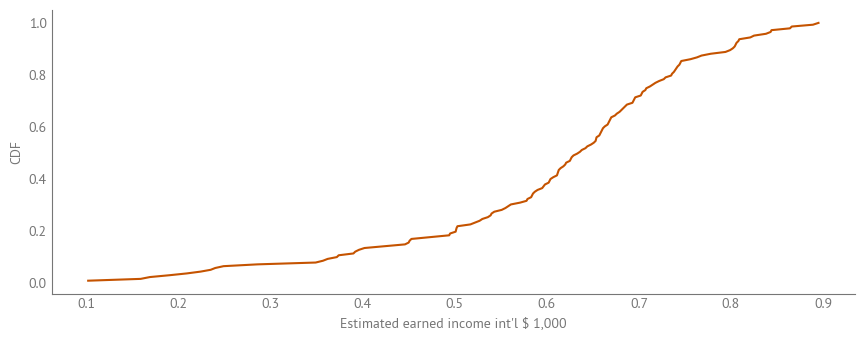

In [10]:
from empiricaldist import Cdf

cdf_score = Cdf.from_seq(df.loc[dinged, 'score'])
cdf_score.plot()
decorate(xlabel=xlabel, ylabel='CDF')

Here is the distribution of differences (female minus male in percentage points) for all countries with valid data.

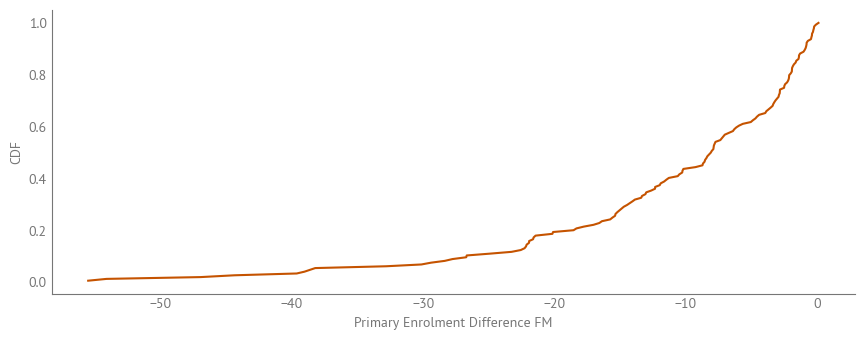

In [11]:
cdf_difference_fm = Cdf.from_seq(df['diff'])
cdf_difference_fm.plot()
decorate(xlabel='Primary Enrolment Difference FM', ylabel='CDF')

In [12]:
subset = df[dinged]
subset.sort_values("diff", ascending=False)

,country,page_number,score,rank,diff,left,right
code,,,,,,,
BDI,Burundi,129,0.843,7.0,-0.12,0.65,0.77
ZWE,Zimbabwe,373,0.895,2.0,-0.25,2.09,2.34
MDG,Madagascar,245,0.838,8.0,-0.27,1.37,1.64
TZA,Tanzania,359,0.889,3.0,-0.31,2.47,2.78
MOZ,Mozambique,267,0.763,21.0,-0.34,1.09,1.42
...,...,...,...,...,...,...,...
KWT,Kuwait,227,0.390,129.0,-39.63,25.30,64.93
SAU,Saudi Arabia,309,0.357,133.0,-44.36,24.63,68.99
QAT,Qatar,303,0.571,101.0,-46.94,62.52,109.46


## Revised scores

The scores are based on ratios, not differences, so let's compute those.

In [13]:
df['ratio'] = df['left'] / df['right']
df['ratio'].describe()

count    144.000000
mean       0.610323
std        0.164518
min        0.101310
25%        0.538165
50%        0.636780
75%        0.712512
max        0.946667
Name: ratio, dtype: float64

Looks like the ratio IS the score.

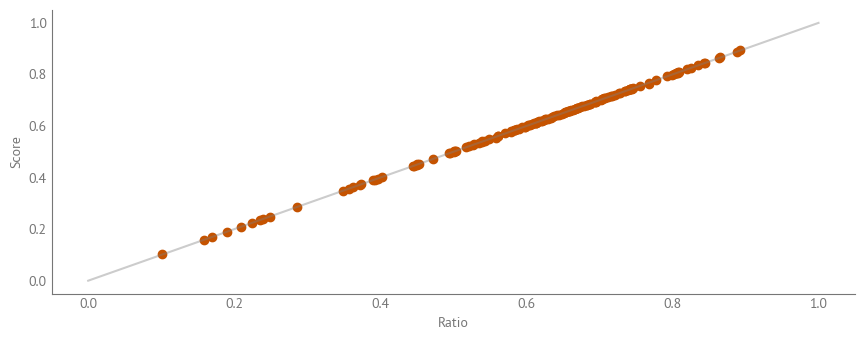

In [14]:
subset = df[dinged]
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(subset['ratio'], subset['score'])
decorate(xlabel='Ratio', ylabel='Score')

So here are the revised, symmetric scores.

In [15]:
df['revised_score'] = df['ratio']
df['revised_score'].describe()

count    144.000000
mean       0.610323
std        0.164518
min        0.101310
25%        0.538165
50%        0.636780
75%        0.712512
max        0.946667
Name: revised_score, dtype: float64

Here's the distribution of revised scores.

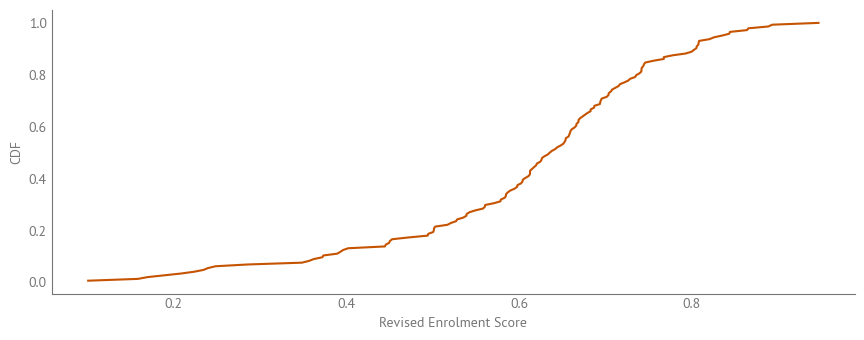

In [16]:
cdf_score = Cdf.from_seq(df['revised_score'])
cdf_score.plot()
decorate(xlabel='Revised Enrolment Score', ylabel='CDF')

Here's the distribution of revised scores, compare to the original.

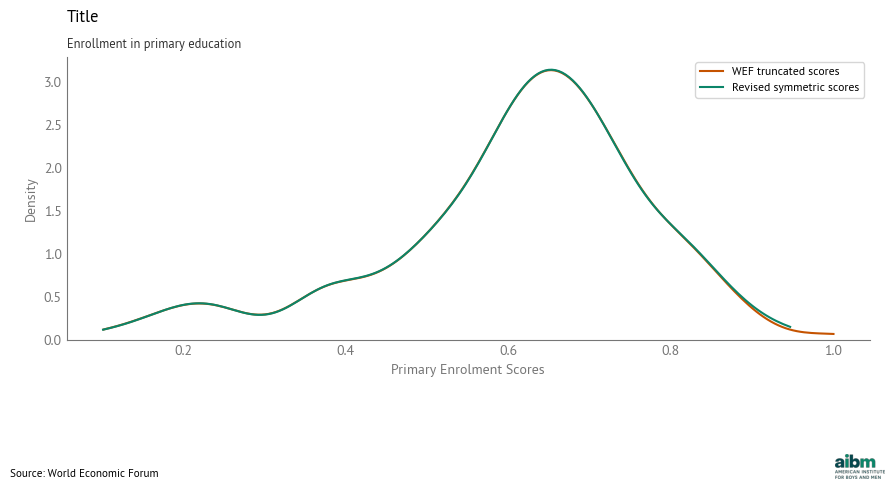

In [17]:
from utils import plot_score_distributions, add_title

plot_score_distributions(df, xlabel='Primary Enrolment Scores')
add_title("Title",
          "Enrollment in primary education")

In [18]:
revised = df[~dinged].dropna(subset=['ratio']).sort_values('revised_score')
revised.shape

(1, 9)

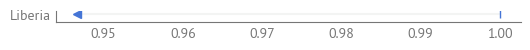

In [19]:
from utils import plot_revised_scores

plot_revised_scores(revised)

## Export the results

In [20]:
from utils import make_rank_table

table = make_rank_table(df)
table.to_csv("wef_earned_income_table.csv")
table.shape

(146, 6)

In [21]:
table['score'].describe()

count    144.000000
mean       0.610736
std        0.165345
min        0.102000
25%        0.538250
50%        0.637000
75%        0.712750
max        1.000000
Name: score, dtype: float64

In [22]:
from utils import make_weight_table

make_weight_table(table, 'professional')

original             revised          
                   std   inv std       std   inv std
professional  0.165345  0.060479  0.164518  0.060784

## OECD countries

In [23]:
from utils import oecd_codes

df_oecd = df.loc[oecd_codes].sort_values(by='revised_score')

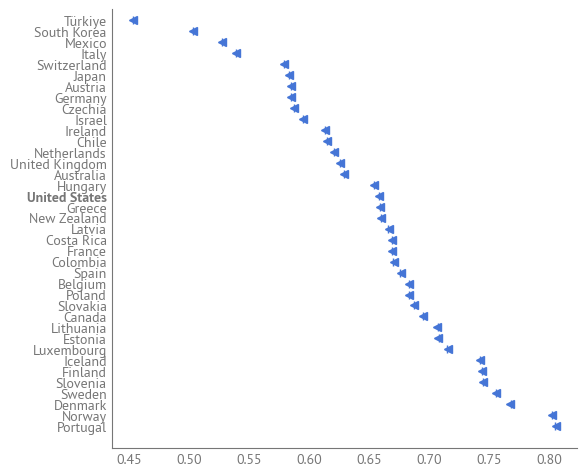

In [24]:
plot_revised_scores(df_oecd)

In [25]:
df.query("country == 'Ireland'")

,country,page_number,score,rank,diff,left,right,ratio,revised_score,revised_rank
code,,,,,,,,,,
IRL,Ireland,211,0.613,83.0,-54.1,85.63,139.73,0.612825,0.612825,83.0
